# Coursera Capstone
# The Battle of the Neighborhoods
This document will be used for the Coursera Capstone project, part of the IBM Data Science Professional Certificate.

In [254]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns

import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import K Nearest Neightbors
from sklearn.neighbors import KNeighborsClassifier

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## Create a dataframe of neighborhoods in Minneapolis
As far as I could tell, the data for Minneapolis neighborhoods did not come attached with latitude and longitude values. The following section creates a dataframe with neighborhood names and attached lat/long values.

In [2]:
# Data retrieved from
# https://opendata.minneapolismn.gov/datasets/minneapolis-neighborhoods
# Data downloaded and placed in local directory

with open('Minneapolis_Neighborhoods.geojson.json') as jsondata:
    mpls_data = json.load(jsondata)

Define `mpls_nbhds` to be the features of the geojson file imported above.

In [3]:
mpls_nbhds = mpls_data['features']

In [62]:
# Look at the first entry. Note the neighborhood name has key 'BDNAME'.
mpls_data

{'type': 'FeatureCollection',
 'name': 'Minneapolis_Neighborhoods',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'FID': 1,
    'BDNAME': 'Phillips West',
    'BDNUM': '90',
    'TEXT_NBR': '90',
    'Shape_STAr': 10669249.7418,
    'Shape_STLe': 14403.8859339,
    'NCR_LINK': 'http://www.nrp.org/r2/Neighborhoods/Orgs/PHW.html',
    'IMAGE': 'PHW',
    'SHAPE_Length': 0.04580106358679052,
    'SHAPE_Area': 0.00011302161937450821},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-93.26258075899995, 44.96090821400003],
       [-93.26258068799996, 44.960896674000026],
       [-93.26257007799995, 44.95912773800006],
       [-93.26257006199995, 44.959125131000064],
       [-93.26257002699998, 44.95911920300006],
       [-93.26257002299997, 44.95911835000004],
       [-93.26257002199998, 44.95911830400007],
       [-93.26257006099996, 44.95909969500008],
       [-93.26257174699998, 44.95

In [6]:
# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
nbhds = pd.DataFrame(columns=column_names)
nbhds

Empty DataFrame
Columns: [Neighborhood, Latitude, Longitude]
Index: []

In [7]:
# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in mpls_nbhds:
    nbhd_name = data['properties']['BDNAME']
    nbhds = nbhds.append({'Neighborhood':nbhd_name}, ignore_index=True)

In [8]:
nbhds.head()

Neighborhood Latitude Longitude
0      Phillips West      NaN       NaN
1      Downtown West      NaN       NaN
2      Downtown East      NaN       NaN
3    Ventura Village      NaN       NaN
4  Sumner - Glenwood      NaN       NaN

#### Populate the latitude and longitude using Geopy

In [9]:
counter = 0
missing_addresses = []
for nbhd in nbhds['Neighborhood']:
    address = nbhd + ', Minneapolis, MN'
    geolocator = Nominatim(user_agent="mpls_explorer")
    location = geolocator.geocode(address)
    if location is None:
        print(address+' is not found on geopy.')
        missing_addresses = missing_addresses +[nbhd]
    else:
        latitude = location.latitude
        longitude = location.longitude
        nbhds['Latitude'][counter] = latitude
        nbhds['Longitude'][counter] = longitude
    counter+=1
print(missing_addresses)
nbhds.head()

Downtown West, Minneapolis, MN is not found on geopy.
Ventura Village, Minneapolis, MN is not found on geopy.
Humboldt Industrial Area, Minneapolis, MN is not found on geopy.
South Uptown, Minneapolis, MN is not found on geopy.
Mid - City Industrial, Minneapolis, MN is not found on geopy.
Nicollet Island - East Bank, Minneapolis, MN is not found on geopy.
['Downtown West', 'Ventura Village', 'Humboldt Industrial Area', 'South Uptown', 'Mid - City Industrial', 'Nicollet Island - East Bank']


Neighborhood Latitude Longitude
0      Phillips West  44.9539  -93.2663
1      Downtown West      NaN       NaN
2      Downtown East   44.975  -93.2599
3    Ventura Village      NaN       NaN
4  Sumner - Glenwood  44.9837  -93.2914

There are 6 neighborhoods that Geopy could not identify. We can manually input these by pulling the location data from a google search.

In [10]:
Downtown_West =[44.9742, -93.2733]
Ventura_Village = [44.9618, -93.2582]
Humboldt_Industrial_Area = [45.0421, -93.3077]
South_Uptown = [44.9411, -93.2911]
Mid_City_Industrial = [44.9989, -93.2178]
Nicollet_Island = [44.9879, -93.2629]

missing_latlon = [Downtown_West, Ventura_Village, Humboldt_Industrial_Area, South_Uptown, Mid_City_Industrial, Nicollet_Island]

In [11]:
missing_dict={}
for j in range(0,6):
    entry ={missing_addresses[j]:missing_latlon[j]}
    missing_dict.update(entry)
missing_dict

{'Downtown West': [44.9742, -93.2733],
 'Ventura Village': [44.9618, -93.2582],
 'Humboldt Industrial Area': [45.0421, -93.3077],
 'South Uptown': [44.9411, -93.2911],
 'Mid - City Industrial': [44.9989, -93.2178],
 'Nicollet Island - East Bank': [44.9879, -93.2629]}

In [12]:
# Fill in missing lat/long values into our dataframe
for j in range(0,6):
    value=nbhds.index[nbhds['Neighborhood']==missing_addresses[j]]
    nbhds.loc[value[0], 'Latitude'] = missing_dict[missing_addresses[j]][0]
    nbhds.loc[value[0], 'Longitude'] = missing_dict[missing_addresses[j]][1]

nbhds.head()

Neighborhood Latitude Longitude
0      Phillips West  44.9539  -93.2663
1      Downtown West  44.9742  -93.2733
2      Downtown East   44.975  -93.2599
3    Ventura Village  44.9618  -93.2582
4  Sumner - Glenwood  44.9837  -93.2914

In [13]:
nbhds.shape

(87, 3)

According to Wikipedia, there are 81 official neighborhoods. Here we tally 87. Some cross-referencing perhaps is in order.

## Use FourSquare API to gather data about breweries in Minneapolis

In [14]:
# Define FourSquare credentials
CLIENT_ID = 'JSN5MX1DKF5XI3CXVZADJMU5LZE5FMLT2COF00LRJDFMFWIK' # your Foursquare ID
CLIENT_SECRET = 'ZST1WYPJCG2J2LGQGUER23BPAC1OMF1BKYC4WQKSSRD3WC1T' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

# Find Minneapolis latitude and longitude
address = 'Minneapolis, MN'
geolocator = Nominatim(user_agent="mpls_explorer")
location = geolocator.geocode(address)
mpls_latitude = location.latitude # neighborhood latitude value
mpls_longitude = location.longitude # neighborhood longitude value

category = '50327c8591d4c4b30a586d5d' # Foursquare category for brewery

radius = 25000 # in meters
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        mpls_latitude,
        mpls_longitude,
        category,
        radius,
        LIMIT)

results = requests.get(url).json()

# The [0] below threw me off. This article helped.
# https://medium.com/@aboutiana/a-brief-guide-to-using-foursquare-api-with-a-hands-on-example-on-python-6fc4d5451203
venues = results['response']['groups'][0]['items']
# tranform venues into a dataframe
#venues
df_brew = pd.json_normalize(venues)
df_brew.head()

referralId  reasons.count  \
0  e-0-4c8d128bc37a6dcb86d0fc7a-0              0   
1  e-0-5047b636e4b04db60102f96d-1              0   
2  e-0-52190bad11d28f3e1ce73946-2              0   
3  e-0-56242508498e6aeb80142c2c-3              0   
4  e-0-5aa9baebff03062a4b1dccba-4              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   
3  [{'summary': 'This spot is popular', 'type': '...   
4  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address venue.location.crossStreet  venue.location.lat  \
0          414 6th Ave N               at 5th St. N           44.984862   
1         1300 2nd St NE                        NaN           45.001049   
2     520 Malcolm Ave SE                  SE 5th St           44.973226   
3       1368 Lasalle Ave                        NaN           44.968908   
4          817 5th Ave S        btwn S 8th & 9th St           44.972301   

   venue.location.lng                      venue.location.labeledLatLngs  ...  \
0          -93.278828  [{'label': 'display', 'lat': 44.98486196804921...  ...   
1          -93.266337  [{'label': 'display', 'lat': 45.00104863763394...  ...   
2          -93.210072  [{'label': 'display', 'lat': 44.97322598772595...  ...   
3          -93.279479  [{'label': 'display', 'lat': 44.96890779142156...  ...   
4          -93.266410  [{'label': 'display', 'lat': 44.97230088563604...  ...   

   venue.photos.count venue.photos.groups     venue.location.neighborhood  \
0                   0                  []                             NaN   
1                   0                  []                             NaN   
2                   0                  []  Prospect Park, Minneapolis, MN   
3                   0                  []                             NaN   
4                   0                  []                             NaN   

  venue.venuePage.id venue.delivery.id venue.delivery.url  \
0                NaN               NaN                NaN   
1                NaN               NaN                NaN   
2                NaN               NaN                NaN   
3          465641085               NaN                NaN   
4                NaN               NaN                NaN   

  venue.delivery.provider.name venue.delivery.provider.icon.prefix  \
0                          NaN                                 NaN   
1                          NaN                                 NaN   
2                          NaN                                 NaN   
3                          NaN                                 NaN   
4                          NaN                                 NaN   

   venue.delivery.provider.icon.sizes venue.delivery.provider.icon.name  
0                                 NaN                               NaN  
1                                 NaN                               NaN  
2                                 NaN                               NaN  
3                                 NaN                               NaN  
4                                 NaN                               NaN  

[5 rows x 28 columns]

In [15]:
df_brew.shape

(100, 28)

In [16]:
df_brew.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id',
       'venue.delivery.id', 'venue.delivery.url',
       'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes',
       'venue.delivery.provider.icon.name'],
      dtype='object')

In [17]:
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']

df_brew.drop(columns = drop_columns, inplace=True)
df_brew.head(10)

venue.id                       venue.name  \
0   4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1   5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2   52190bad11d28f3e1ce73946            Surly Brewing Company   
3   56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4   5aa9baebff03062a4b1dccba                  Finnegans House   
5   570d7c00cd102c0fabd7d768                   Inbound BrewCo   
6   52d4225b498e07070c180a62                 Sisyphus Brewing   
7   4f3dcd09e4b0e4bab927d3d6           Indeed Brewing Company   
8   41326e00f964a52060171fe3    Minneapolis Town Hall Brewery   
9   51f2d31c498eed6962fdc888        Day Block Brewing Company   
10  5708377a498ed6d539a0ae7b              Utepils Brewing Co.   
11  51e727f9011cf34b0dcf44fe    Urban Growler Brewing Company   
12  5655f13b498efec375b04a8c                Modist Brewing Co   
13  586332f4761b1a5ec7d3954a            Pryes Brewing Company   
14  5a2b0aab35f9833b4c7807a4                     Venn Brewing   
15  53286dcd498ec2cc97ce9ce1   Fair State Brewing Cooperative   
16  53286e45498e19b6016298b4                Bauhaus Brew Labs   
17  5352dbbb498e0bbe7896752e                  Insight Brewing   
18  58f28377780eee39655ed7f8                Headflyer Brewing   
19  527bb8a511d2e7d7239d2c41             Sociable Cider Werks   

       venue.location.address  venue.location.lat  venue.location.lng  
0               414 6th Ave N           44.984862          -93.278828  
1              1300 2nd St NE           45.001049          -93.266337  
2          520 Malcolm Ave SE           44.973226          -93.210072  
3            1368 Lasalle Ave           44.968908          -93.279479  
4               817 5th Ave S           44.972301          -93.266410  
5        701 North 5th Street           44.985640          -93.281496  
6           712 Ontario Ave W           44.973214          -93.289040  
7     711 15th Ave NE Ste 102           45.003368          -93.251563  
8       1430 Washington Ave S           44.973320          -93.247628  
9       1105 Washington Ave S           44.975190          -93.253207  
10           225 Thomas Ave N           44.979111          -93.312605  
11           2325 Endicott St           44.970050          -93.192763  
12               505 N 3rd St           44.985085          -93.276370  
13       1401 N West River Rd           44.993574          -93.276250  
14     3550 E 46th St Apt 140           44.920067          -93.219557  
15        2506 Central Ave NE           45.013547          -93.247677  
16           1315 Tyler St NE           45.001022          -93.244920  
17  2821 East Hennepin Avenue           44.991930          -93.212950  
18         861 E Hennepin Ave           44.991660          -93.243764  
19        1500 Fillmore St NE           45.003412          -93.242374

In [28]:
df_brew.tail()

venue.id                 venue.name  \
95  4dd9aa848877f115102094a5             The Beamer Bar   
96  4283ee00f964a520b1221fe3             Chatterbox Pub   
97  4de30667ae60e7f3abfeadd7        Black & Tan Brewery   
98  5d71a01fb3950a00079d87f0      Falling Knife Brewing   
99  5bf5a33dc03635002cc313a8  Minneapolis Cider Company   

   venue.location.address  venue.location.lat  venue.location.lng  
95         2008 2nd Ave S           44.962178          -93.274213  
96         2229 E 35th St           44.939535          -93.239138  
97      2227 Monroe St NE           45.010180          -93.252054  
98      783 Harding St NE           44.998394          -93.221090  
99      701 SE 9th Street           44.989450          -93.241404

### Clean and format brewery data

By looking at the columns and head, we see some candidates for removal. For example, the second listing is the twincities brewery tours, which is not actually a brewery. Additionally, its `location.address` is NaN. This row is a candidate for removal. Let's see if we can further whittle this data set down.

### Visualizing breweries and neighborhoods
The neighborhood data is not attached to the brewery locations. To generate the Choropleth map, we would need this. It could be done manually, but that may be more effort than I want. On the other hand, should be able to overlay the neighborhood grids with the brewery markers.


In [225]:
mpls_map = folium.Map(location=[mpls_latitude, mpls_longitude], zoom_start=13)

#### Add breweries to map

In [226]:
# Create brewery instances
breweries = folium.map.FeatureGroup()

for lat, lon in zip(df_brew['venue.location.lat'], df_brew['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='blue',
        fill=True,
#        popup=label,
        fill_color='magenta',
        fill_opacity=0.6
    ).add_to(mpls_map)
    

# add breweries to map


In [227]:
mpls_map

#### Add neighborhoods to map

In [99]:
folium.GeoJson(mpls_data).add_to(mpls_map)

#### Cluster breweries
This code may be skipped when running. At the moment, not sure it adds too much other than clutter.

In [93]:
breweries_cluster = plugins.MarkerCluster().add_to(mpls_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng in zip(df_brew['venue.location.lat'], df_brew['venue.location.lng']):
    folium.Marker(
        location=[lat, lng],
        icon=None
#        popup=label,
    ).add_to(breweries_cluster)
mpls_map

## Use FourSquare to gather data about restaurants in Minneapolis

In [94]:
category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)

radius = 25000 # in meters
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        mpls_latitude,
        mpls_longitude,
        category,
        radius,
        LIMIT)

results = requests.get(url).json()

# The [0] below threw me off. This article helped.
# https://medium.com/@aboutiana/a-brief-guide-to-using-foursquare-api-with-a-hands-on-example-on-python-6fc4d5451203
venues = results['response']['groups'][0]['items']
# tranform venues into a dataframe
#venues
df_food = pd.json_normalize(venues)
df_food.head()

referralId  reasons.count  \
0  e-0-54d26ae7498ec505d9d96438-0              0   
1  e-0-4e88d22e722e9cffb47a9b28-1              0   
2  e-0-593c34d36a59504d32cb636e-2              0   
3  e-0-4e7a75087d8bf4f6a24576ed-3              0   
4  e-0-49aac49af964a520ab521fe3-4              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   
3  [{'summary': 'This spot is popular', 'type': '...   
4  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng  \
0          208 1st Ave N           44.983419          -93.269666   
1      1121 Hennepin Ave           44.974860          -93.279780   
2           530 N 3rd St           44.986129          -93.276732   
3   602 Washington Ave S           44.978361          -93.259708   
4   600 Washington Ave N           44.987033          -93.275933   

                       venue.location.labeledLatLngs  venue.location.distance  \
0  [{'label': 'display', 'lat': 44.98341898703361...                      757   
1  [{'label': 'display', 'lat': 44.97485992074971...                     1159   
2  [{'label': 'display', 'lat': 44.98612860152806...                     1323   
3  [{'label': 'display', 'lat': 44.97836124396489...                      468   
4  [{'label': 'display', 'lat': 44.98703328103842...                     1361   

   ... venue.photos.groups       venue.location.crossStreet  \
0  ...                  []                              NaN   
1  ...                  []       btwn 11th St N & 12th St N   
2  ...                  []                              NaN   
3  ...                  []  Corner of Washington & Portland   
4  ...                  []                     at 6th Ave N   

  venue.location.neighborhood venue.venuePage.id venue.delivery.id  \
0                         NaN                NaN               NaN   
1               Downtown West           59729362               NaN   
2                         NaN                NaN           1540075   
3                         NaN                NaN               NaN   
4                         NaN                NaN               NaN   

                                  venue.delivery.url  \
0                                                NaN   
1                                                NaN   
2  https://www.grubhub.com/restaurant/rise-bagel-...   
3                                                NaN   
4                                                NaN   

  venue.delivery.provider.name       venue.delivery.provider.icon.prefix  \
0                          NaN                                       NaN   
1                          NaN                                       NaN   
2                      grubhub  https://fastly.4sqi.net/img/general/cap/   
3                          NaN                                       NaN   
4                          NaN                                       NaN   

  venue.delivery.provider.icon.sizes        venue.delivery.provider.icon.name  
0                                NaN                                      NaN  
1                                NaN                                      NaN  
2                           [40, 50]  /delivery_provider_grubhub_20180129.png  
3                                NaN                                      NaN  
4                                NaN                                      NaN  

[5 rows x 28 columns]

Drop similar columns as above.

In [95]:
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']

df_food.drop(columns = drop_columns, inplace=True)
df_food.head()

venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng  
0          208 1st Ave N           44.983419          -93.269666  
1      1121 Hennepin Ave           44.974860          -93.279780  
2           530 N 3rd St           44.986129          -93.276732  
3   602 Washington Ave S           44.978361          -93.259708  
4   600 Washington Ave N           44.987033          -93.275933

### Look at restaurants on map

In [131]:
# Create brewery instances
restaurants = folium.map.FeatureGroup()

for lat, lon in zip(df_food['venue.location.lat'], df_food['venue.location.lng']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='red',
        fill=True,
#        popup=label,
        fill_color='pink',
        fill_opacity=0.6
    ).add_to(mpls_map)
    

# add breweries to map
mpls_map


In [128]:
# Add the minneapolis center point to the map

folium.features.CircleMarker(
    [mpls_latitude, mpls_longitude],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map)

# Add dinkytown center point to the map
dinky_lat = 44.9805
dinky_lon = -93.2358

folium.features.CircleMarker(
    [dinky_lat, dinky_lon],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map)    

# Add Uptown center point to map
uptown_lat = 44.9490
uptown_lon = -93.2999

folium.features.CircleMarker(
    [uptown_lat, uptown_lon],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map)    

# Add Longfellow center point to map
longfellow_lat = 44.9484
longfellow_lon = -93.2343

folium.features.CircleMarker(
    [longfellow_lat, longfellow_lon],
    radius=10,
    color='green',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6).add_to(mpls_map) 
    
mpls_map 

## Pad the restaurant list.
To gather more restaurants, we call the foursquare API but centered around Dinkytown, Uptown, and Longfellow.

In [129]:
# Dinkytown
category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)

radius = 5000 # in meters
LIMIT = 200

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, VERSION, dinky_lat, dinky_lon, category, radius, LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
df_dinky = pd.json_normalize(venues)
df_dinky.drop(columns = drop_columns, inplace=True)

# Uptown
uptown_lat = 44.9490
uptown_lon = -93.2999

url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, VERSION, uptown_lat, uptown_lon, category, radius, LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
df_uptown= pd.json_normalize(venues)
df_uptown.drop(columns = drop_columns, inplace=True)

# Longfellow
longfellow_lat = 44.9484
longfellow_lon = -93.2343
url = 'https://api.foursquare.com/v2/venues/\
explore?client_id={}&client_secret={}&v={}\
&ll={},{}&categoryId={}&radius={}&limit={}'\
.format(CLIENT_ID, CLIENT_SECRET, VERSION, longfellow_lat, longfellow_lon, category, radius, LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
df_longfellow= pd.json_normalize(venues)
df_longfellow.drop(columns = drop_columns, inplace=True)



In [130]:
# Merge dataframes and drop duplicate values.
print(df_food.shape)
df_food = pd.concat([df_food, df_dinky, df_uptown, df_longfellow]).drop_duplicates().reset_index(drop=True)
print(df_food.shape)

(109, 5)
(219, 5)


In [150]:
df_food.head()

venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng  
0          208 1st Ave N           44.983419          -93.269666  
1      1121 Hennepin Ave           44.974860          -93.279780  
2           530 N 3rd St           44.986129          -93.276732  
3   602 Washington Ave S           44.978361          -93.259708  
4   600 Washington Ave N           44.987033          -93.275933

## Add ratings to restaurant list

In [163]:
# Code to add venue ratings to the dataframe.
def get_rating():
    try:
        return results['response']['venue']['rating']
    except:
        return 'No ratings yet'

# Initialize list of ratings
ratings=[]
for venue_id in df_food['venue.id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(str(venue_id), CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    ratings.append(get_rating())

# Populate ratings column
df_food['venue.rating'] = pd.Series(ratings)

In [172]:
venue_id = '48eefdcdf964a5203c521fe3'

url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
results = requests.get(url).json()
get_rating()


'No ratings yet'

In [173]:
results

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5f10a17c68c07a184cf83253'},
 'response': {}}

## Look at 2019 Police Data

In [174]:
df_police = pd.read_csv('Police_Incidents_2019.csv')
df_police.head()

X          Y        publicaddress            caseNumber precinct  \
0 -93.265033  44.977760      0003XX 4TH ST S  MP2019248516           1        
1 -93.244857  44.945648    0031XX 19TH AVE S  MP2019253346           3        
2 -93.293204  45.030536  0041XX DUPONT AVE N  MP2019253392           4        
3 -93.278804  44.948344     00001X LAKE ST W  MP2019253470           5        
4 -93.305206  44.948427     0018XX LAKE ST W  MP2019253486           5        

             reportedDate  reportedTime               beginDate  \
0  2019/08/19 00:00:00+00             0  2019/08/12 00:00:00+00   
1  2019/08/23 00:00:00+00          1150  2019/08/22 00:00:00+00   
2  2019/08/23 00:00:00+00          1606  2019/08/23 00:00:00+00   
3  2019/08/23 00:00:00+00          1420  2019/08/23 00:00:00+00   
4  2019/08/23 00:00:00+00          1513  2019/08/10 00:00:00+00   

         reportedDateTime  beginTime  ...             enteredDate centergbsid  \
0  2019/08/19 00:00:00+00          0  ...  2019/08/19 00:00:00+00     18596.0   
1  2019/08/23 11:50:00+00       1606  ...  2019/08/24 00:00:00+00     13244.0   
2  2019/08/23 16:06:00+00       1220  ...  2019/08/24 00:00:00+00     10605.0   
3  2019/08/23 14:20:00+00       1330  ...  2019/08/24 00:00:00+00     21928.0   
4  2019/08/23 15:13:00+00        452  ...  2019/08/24 00:00:00+00     19969.0   

   centerLong  centerLat   centerX  centerY     neighborhood  \
0  -93.265034  44.977764 -10382216  5618021    Downtown West   
1  -93.244863  44.945650 -10379970  5612969         Corcoran   
2  -93.293211  45.030541 -10385352  5626330  Webber - Camden   
3  -93.278808  44.948347 -10383749  5613393         Whittier   
4  -93.305210  44.948430 -10386688  5613406             ECCO   

              lastchanged       LastUpdateDateETL OBJECTID  
0  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        1  
1  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        2  
2  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        3  
3  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        4  
4  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        5  

[5 rows x 23 columns]

In [175]:
df_police.shape

(22934, 23)

In [177]:
df_police.rename(columns = {'X':'Longitude','Y':'Latitude'}, inplace=True)
df_police.head()

Longitude   Latitude        publicaddress            caseNumber precinct  \
0 -93.265033  44.977760      0003XX 4TH ST S  MP2019248516           1        
1 -93.244857  44.945648    0031XX 19TH AVE S  MP2019253346           3        
2 -93.293204  45.030536  0041XX DUPONT AVE N  MP2019253392           4        
3 -93.278804  44.948344     00001X LAKE ST W  MP2019253470           5        
4 -93.305206  44.948427     0018XX LAKE ST W  MP2019253486           5        

             reportedDate  reportedTime               beginDate  \
0  2019/08/19 00:00:00+00             0  2019/08/12 00:00:00+00   
1  2019/08/23 00:00:00+00          1150  2019/08/22 00:00:00+00   
2  2019/08/23 00:00:00+00          1606  2019/08/23 00:00:00+00   
3  2019/08/23 00:00:00+00          1420  2019/08/23 00:00:00+00   
4  2019/08/23 00:00:00+00          1513  2019/08/10 00:00:00+00   

         reportedDateTime  beginTime  ...             enteredDate centergbsid  \
0  2019/08/19 00:00:00+00          0  ...  2019/08/19 00:00:00+00     18596.0   
1  2019/08/23 11:50:00+00       1606  ...  2019/08/24 00:00:00+00     13244.0   
2  2019/08/23 16:06:00+00       1220  ...  2019/08/24 00:00:00+00     10605.0   
3  2019/08/23 14:20:00+00       1330  ...  2019/08/24 00:00:00+00     21928.0   
4  2019/08/23 15:13:00+00        452  ...  2019/08/24 00:00:00+00     19969.0   

   centerLong  centerLat   centerX  centerY     neighborhood  \
0  -93.265034  44.977764 -10382216  5618021    Downtown West   
1  -93.244863  44.945650 -10379970  5612969         Corcoran   
2  -93.293211  45.030541 -10385352  5626330  Webber - Camden   
3  -93.278808  44.948347 -10383749  5613393         Whittier   
4  -93.305210  44.948430 -10386688  5613406             ECCO   

              lastchanged       LastUpdateDateETL OBJECTID  
0  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        1  
1  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        2  
2  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        3  
3  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        4  
4  2019/08/24 00:00:00+00  2019/08/25 08:15:46+00        5  

[5 rows x 23 columns]

### Binning geographical data

In [183]:
df_brew['lat_bin']=pd.cut(df_brew['venue.location.lat'], 2, labels=['South','North'])

In [186]:
df_brew['lon_bin']=pd.cut(df_brew['venue.location.lng'], 2, labels=['West','East'])
df_brew.head(10)

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   
5  570d7c00cd102c0fabd7d768                   Inbound BrewCo   
6  52d4225b498e07070c180a62                 Sisyphus Brewing   
7  4f3dcd09e4b0e4bab927d3d6           Indeed Brewing Company   
8  41326e00f964a52060171fe3    Minneapolis Town Hall Brewery   
9  51f2d31c498eed6962fdc888        Day Block Brewing Company   

    venue.location.address  venue.location.lat  venue.location.lng lat_bin  \
0            414 6th Ave N           44.984862          -93.278828   South   
1           1300 2nd St NE           45.001049          -93.266337   North   
2       520 Malcolm Ave SE           44.973226          -93.210072   South   
3         1368 Lasalle Ave           44.968908          -93.279479   South   
4            817 5th Ave S           44.972301          -93.266410   South   
5     701 North 5th Street           44.985640          -93.281496   South   
6        712 Ontario Ave W           44.973214          -93.289040   South   
7  711 15th Ave NE Ste 102           45.003368          -93.251563   North   
8    1430 Washington Ave S           44.973320          -93.247628   South   
9    1105 Washington Ave S           44.975190          -93.253207   South   

  lon_bin  
0    East  
1    East  
2    East  
3    East  
4    East  
5    West  
6    West  
7    East  
8    East  
9    East

In [194]:
def geo(series, k):
    if series['lat_bin'][k]=='South':
        if series['lon_bin'][k] == 'West':
            return 'SW'
        if series['lon_bin'][k] == 'East':
            return 'SE'
        else:
            return 'Nope!'
    if series['lat_bin'][k]=='North':
        if series['lon_bin'][k] == 'West':
            return 'NW'
        if series['lon_bin'][k] == 'East':
            return 'NE'
        else:
            return 'Nope!'
    else:
        return 'Double Nope!'
quartiles = []
for row in range(0, len(df_brew)):
    quartiles.append(geo(df_brew,row))
df_brew['quartile']=pd.Series(quartiles)

In [195]:
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng lat_bin  \
0          414 6th Ave N           44.984862          -93.278828   South   
1         1300 2nd St NE           45.001049          -93.266337   North   
2     520 Malcolm Ave SE           44.973226          -93.210072   South   
3       1368 Lasalle Ave           44.968908          -93.279479   South   
4          817 5th Ave S           44.972301          -93.266410   South   

  lon_bin quartile  
0    East       SE  
1    East       NE  
2    East       SE  
3    East       SE  
4    East       SE

In [214]:
print(df_brew.groupby('quartile').count())

          venue.id  venue.name  venue.location.address  venue.location.lat  \
quartile                                                                     
NE              23          23                      23                  23   
NW               8           8                       8                   8   
SE              53          53                      52                  53   
SW              16          16                      16                  16   

          venue.location.lng  lat_bin  lon_bin  
quartile                                        
NE                        23       23       23  
NW                         8        8        8  
SE                        53       53       53  
SW                        16       16       16  


In [216]:
ax = sns.heatmap(df_brew)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

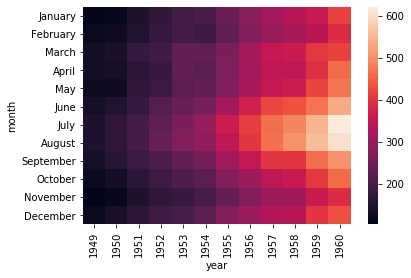

In [217]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [218]:
flights

year       1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
month                                                                         
January     112   115   145   171   196   204   242   284   315   340   360   
February    118   126   150   180   196   188   233   277   301   318   342   
March       132   141   178   193   236   235   267   317   356   362   406   
April       129   135   163   181   235   227   269   313   348   348   396   
May         121   125   172   183   229   234   270   318   355   363   420   
June        135   149   178   218   243   264   315   374   422   435   472   
July        148   170   199   230   264   302   364   413   465   491   548   
August      148   170   199   242   272   293   347   405   467   505   559   
September   136   158   184   209   237   259   312   355   404   404   463   
October     119   133   162   191   211   229   274   306   347   359   407   
November    104   114   146   172   180   203   237   271   305   310   362   
December    118   140   166   194   201   229   278   306   336   337   405   

year       1960  
month            
January     417  
February    391  
March       419  
April       461  
May         472  
June        535  
July        622  
August      606  
September   508  
October     461  
November    390  
December    432

In [219]:
flights = sns.load_dataset("flights")
flights

year      month  passengers
0    1949    January         112
1    1949   February         118
2    1949      March         132
3    1949      April         129
4    1949        May         121
..    ...        ...         ...
139  1960     August         606
140  1960  September         508
141  1960    October         461
142  1960   November         390
143  1960   December         432

[144 rows x 3 columns]

In [223]:
x=pd.Series(df_brew['venue.location.lat'].value_counts(bins=10))

In [224]:
x

(44.959, 44.994]    38
(44.994, 45.029]    18
(44.924, 44.959]    17
(44.889, 44.924]     8
(45.029, 45.064]     5
(45.064, 45.099]     4
(44.853, 44.889]     3
(44.817, 44.853]     3
(45.134, 45.17]      2
(45.099, 45.134]     2
Name: venue.location.lat, dtype: int64

## CLuster restaurant regions vs brewery regions

Supervised: restaurant vs brewery
high density brewery vs high density restaurant
Want to build brewery in region lots of restaurants, low brewery density.


In [235]:
np.ones(3)

array([1., 1., 1.])

In [234]:
df_food['type'] = pd.Series(np.zeros(len(df_food)))
df_food.head()

venue.id                    venue.name  \
0  54d26ae7498ec505d9d96438                       Red Cow   
1  4e88d22e722e9cffb47a9b28            Butcher & the Boar   
2  593c34d36a59504d32cb636e                Rise Bagel Co.   
3  4e7a75087d8bf4f6a24576ed               Zen Box Izakaya   
4  49aac49af964a520ab521fe3  Black Sheep Coal Fired Pizza   

  venue.location.address  venue.location.lat  venue.location.lng venue.rating  \
0          208 1st Ave N           44.983419          -93.269666            9   
1      1121 Hennepin Ave           44.974860          -93.279780          9.2   
2           530 N 3rd St           44.986129          -93.276732          9.3   
3   602 Washington Ave S           44.978361          -93.259708          8.9   
4   600 Washington Ave N           44.987033          -93.275933          9.3   

   type  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0

In [236]:
df_brew['type'] = pd.Series(np.ones(len(df_brew)))
df_brew.head()

venue.id                       venue.name  \
0  4c8d128bc37a6dcb86d0fc7a           Fulton Brewing Company   
1  5047b636e4b04db60102f96d         Dangerous Man Brewing Co   
2  52190bad11d28f3e1ce73946            Surly Brewing Company   
3  56242508498e6aeb80142c2c  Lakes & Legends Brewing Company   
4  5aa9baebff03062a4b1dccba                  Finnegans House   

  venue.location.address  venue.location.lat  venue.location.lng lat_bin  \
0          414 6th Ave N           44.984862          -93.278828   South   
1         1300 2nd St NE           45.001049          -93.266337   North   
2     520 Malcolm Ave SE           44.973226          -93.210072   South   
3       1368 Lasalle Ave           44.968908          -93.279479   South   
4          817 5th Ave S           44.972301          -93.266410   South   

  lon_bin quartile  type  
0    East       SE   1.0  
1    East       NE   1.0  
2    East       SE   1.0  
3    East       SE   1.0  
4    East       SE   1.0

In [237]:
combined = df_food[['venue.location.lat', 'venue.location.lng', 'type']]
combined.head()

venue.location.lat  venue.location.lng  type
0           44.983419          -93.269666   0.0
1           44.974860          -93.279780   0.0
2           44.986129          -93.276732   0.0
3           44.978361          -93.259708   0.0
4           44.987033          -93.275933   0.0

In [239]:
XX = pd.concat([combined, df_brew[['venue.location.lat', 'venue.location.lng', 'type']]]).reset_index(drop=True)
XX.head()

venue.location.lat  venue.location.lng  type
0           44.983419          -93.269666   0.0
1           44.974860          -93.279780   0.0
2           44.986129          -93.276732   0.0
3           44.978361          -93.259708   0.0
4           44.987033          -93.275933   0.0

In [240]:
XX.tail()

venue.location.lat  venue.location.lng  type
314           44.962178          -93.274213   1.0
315           44.939535          -93.239138   1.0
316           45.010180          -93.252054   1.0
317           44.998394          -93.221090   1.0
318           44.989450          -93.241404   1.0

In [256]:
X = XX.values

In [257]:
X = X[:,0:2]
y = XX['type'].values
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1.

In [272]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

k=15
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=k))])

scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [0.3125     0.28125    0.28125    0.203125   0.22222222]


In [294]:
k=10
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)

yhat = neigh.predict(X_test)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7764705882352941
Test set Accuracy:  0.828125


In [275]:
 my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=k))])

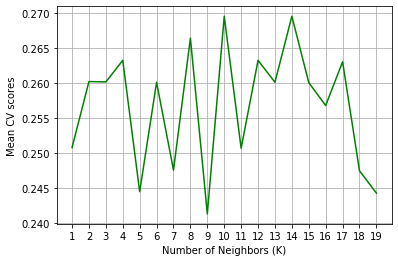

In [282]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

mean_scores=[]

for n in range(1,Ks):
    #Train Model and Predict  
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors=n))])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    mean_scores.append(scores.mean())

#    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
#    yhat=neigh.predict(X_test)
#    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
#    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#mean_acc

plt.plot(range(1,Ks),mean_scores,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
#plt.legend(('Accuracy ', '+/- 3xstd'))
#plt.ylabel('Accuracy ')
plt.ylabel('Mean CV scores')
plt.xlabel('Number of Neighbors (K)')
plt.xticks(range(1,Ks))
plt.grid()
#plt.tight_layout()
plt.show()

In [285]:
print(mean_scores[9])
print(mean_scores[13])

0.2695436507936508
0.2695436507936508


Use 10 neighbors or 14 neighbors.

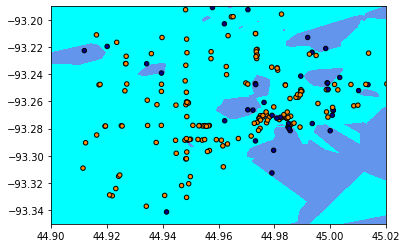

In [312]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

#n_neighbors = 
k=2
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
yhat = neigh.predict(X_test)

# import some data to play with
#iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
#X = iris.data[:, :2]
#y = iris.target

h = 0.0001  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

#for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    #clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    #clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = 44.9, 45.02
y_min, y_max = -93.35, -93.19
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
yhat = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
yhat = yhat.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.title("3-Class classification (k = %i, weights = '%s')"
#              % (n_neighbors, weights))

plt.show()

In [293]:
[(XX['venue.location.lat'].max()-XX['venue.location.lat'].min())/100, (XX['venue.location.lng'].max()-XX['venue.location.lng'].min())/100]

[0.0035138193599135547, 0.005493405446240019]

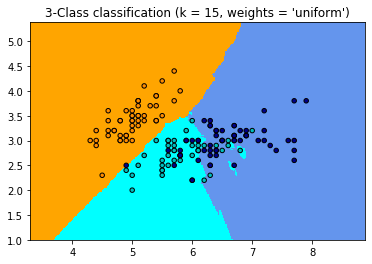

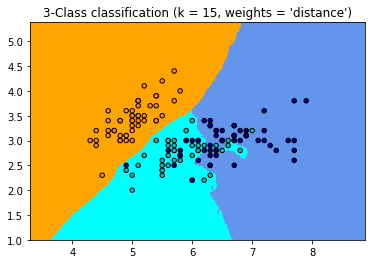

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()
